In [63]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import seaborn as sns
from sklearn.svm import SVC
colors = ['#37535e', '#3b748a', '#4095b5', '#52aec9', '#72bfc4', '#93d0bf']
%matplotlib inline
plt.style.use('fivethirtyeight')

In [64]:
hist = pd.read_csv("../datasets/clean_hist_sub.csv", index_col = False)
cons = pd.read_csv("../datasets/clean_cons_sub.csv", index_col = False)

In [65]:
# Create the target vector , 0 for positive (is in history), 1 for negative
hist['is_hist'] = 0
cons['is_hist'] = 1

# Merge the dataframe
df = hist.append(cons, sort=True)
df = df[['is_hist', 'title','author']]

# Split the target vector from the dataframe
y = df['is_hist']
df.drop(['is_hist'], inplace=True, axis=1)
df.head()

,title,author
0,Organising Your Family History,chiddicks
1,Helen,atumhal
2,Early American colonists sometimes referred to...,ValleDaFighta
3,Did subsaharan African civilizations have dome...,dovetc
4,After Cannae did Hannibal have the resources n...,Anglicanpolitics123


In [66]:
df.shape

(2695, 2)

In [67]:
y.shape

(2695,)

Making sure we have equal values in both sets.

In [68]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = .5, random_state = 42, stratify = y)

## Count Vectorizer

In [69]:
# instantiating CountVectorizer, with the only parameter of English stopwords

cv = CountVectorizer(stop_words='english') 

In [70]:
X_train_cv = cv.fit_transform(X_train['title']) # fit and transform our train data and transform our test
X_test_cv = cv.transform(X_test['title'])

In [71]:
cv_train = pd.DataFrame(X_train_cv.todense(), columns=cv.get_feature_names()) # saving as a DF to plot

In [72]:
# Create a data frame of the most common words 

n_words = 25 # let's return the top 25 most common words
words = list(cv_train.sum().sort_values(ascending=False)[:n_words].index)
cv_train['is_hist'] = y_train.values
cv_train_small = cv_train.groupby('is_hist').sum()[words]
cv_train_small.head()

,did,coronavirus,history,war,people,kobe,virus,china,world,think,...,just,conspiracy,modern,good,american,wuhan,like,corona,trump,empire
is_hist,,,,,,,,,,,,,,,,,,,,,
0,115,0,80,67,37,0,0,5,28,15,...,20,0,28,17,23,0,17,0,2,23
1,13,110,1,10,21,52,50,39,9,20,...,9,28,0,11,4,27,9,25,22,0


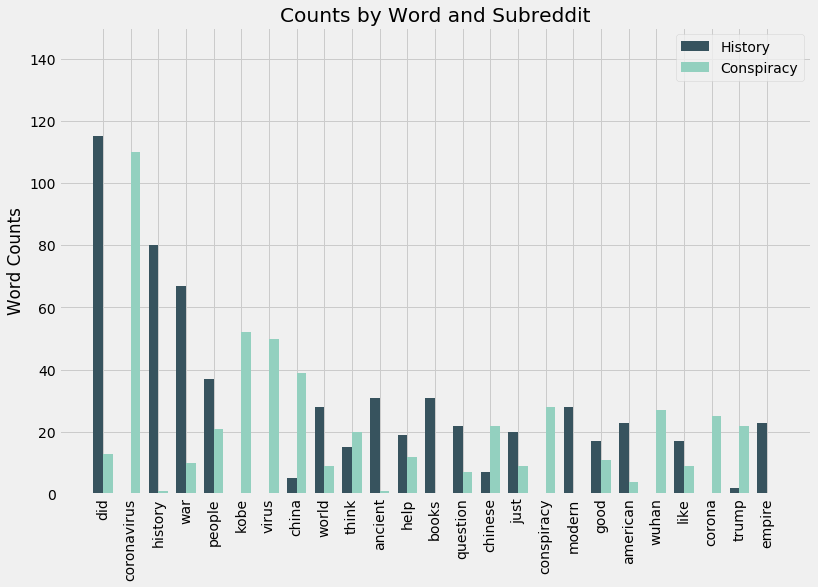

In [73]:
# based on https://matplotlib.org/examples/api/barchart_demo.html
# graphing our chart above

words_hist = words 
words_count_hist = cv_train_small.loc[0]
words_cons = words
words_count_cons = cv_train_small.loc[1] # telling .loc the location of each set
width = 0.35       # the width of the bars
ind = np.arange(n_words)

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(ind, words_count_hist, width, color=colors[0])
rects2 = ax.bar(ind+width,words_count_cons, width, color=colors[5])

# add some text for labels, title and axes ticks
ax.set_ylabel('Word Counts')
ax.set_title('Counts by Word and Subreddit')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(words,rotation='vertical')

ax.set_ylim(0,150)

ax.legend((rects1[0], rects2[0]), ('History', 'Conspiracy'))

plt.show()

While most of the common words are thing you expect such as "did", "history,", "conspiracy and "people" there are a few interesting things to pick out.

War, ancient, empire, German, and Roman are all interesting datapoints in what sort of history questions are popular on the history subreddit and the amount of Kobe, virus, China, coronavirus, and Trump make sense as being hot topics of discussion in conspiracy circles.

## Naive Bayes Prediction Model

In [74]:
naive_bayes = MultinomialNB() # instatiate the model

In [75]:
%%time

naive_bayes.fit(X_train_cv, y_train)

CPU times: user 2.29 ms, sys: 1.35 ms, total: 3.63 ms
Wall time: 2.45 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [76]:
naive_bayes.score(X_train_cv, y_train), naive_bayes.score(X_test_cv, y_test)

(0.9821826280623608, 0.9324925816023739)

In [77]:
preds = naive_bayes.predict(X_test_cv)

cm = confusion_matrix(y_test, preds)

cm_df = pd.DataFrame(cm, columns=['Predicted History', 'Predicted Conspiracy'], 
                     index=['Actual History', 'Actual Conspiracy'])
cm_df

,Predicted History,Predicted Conspiracy
Actual History,656,48
Actual Conspiracy,43,601


In [78]:
# Save TN/FP/FN/TP values and print out the sensitivity and specificity.

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel() # Note that .ravel() will arrange items in 1d array
spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

roc = roc_auc_score(y_test, naive_bayes.predict(X_test_cv)) # finding the area under the curve

print(f'ROC AUC Score: {round(roc,4)}')

Specificity: 0.9318
Sensitivity: 0.9332
ROC AUC Score: 0.9325


Despite a good score, it the 5% difference suggest that our model is overfitting the training data and erring on the side of false positives.

## Logistic Regression with Count Vectorizer

In [79]:
# setting up a Gridsearch LR model to try both Ridge and Lasso parameters to see what works best

grid_logreg = GridSearchCV(LogisticRegression(), param_grid = {'penalty': ['l1', 'l2'], 
                                                               'C': [1e3, 1e4, 1e5]})

In [80]:
%%time

grid_logreg.fit(X_train_cv, y_train) # fit the model to our transformed data.shape

CPU times: user 105 ms, sys: 2 ms, total: 107 ms
Wall time: 106 ms


/Users/dylanblough/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/dylanblough/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1000.0, 10000.0, 100000.0],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [81]:
preds = grid_logreg.predict(X_test_cv) # getting a baseline for the model
confusion_matrix(y_test, preds) # True values of preds

array([[672,  32],
       [ 39, 605]])

In [82]:
preds = grid_logreg.predict(X_test_cv) # getting a baseline for the model
cm = confusion_matrix(y_test, preds)
cm_df = pd.DataFrame(cm, columns=['Predicted History', 'Predicted Conspiracy'], index=['Actual History', 'Actual Conspiracy'])
cm_df

,Predicted History,Predicted Conspiracy
Actual History,672,32
Actual Conspiracy,39,605


In [83]:
# Save TN/FP/FN/TP values and print out the sensitivity and specificity.

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel() # Note that .ravel() will arrange items in 1d array
spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

roc = roc_auc_score(y_test, grid_logreg.predict(X_test_cv)) # finding the area under the curve

print(f'ROC AUC Score: {round(roc,4)}')

Specificity: 0.9545
Sensitivity: 0.9394
ROC AUC Score: 0.947


In [84]:
grid_logreg.score(X_train_cv, y_train), grid_logreg.score(X_test_cv, y_test)

(1.0, 0.9473293768545994)

In [85]:
roc_auc_score(y_test, grid_logreg.predict(X_test_cv)) # finding the area under the curve

0.9469932241671373

In [86]:
grid_logreg.best_params_ # look at the best parameters the GridSearch found

{'C': 1000.0, 'penalty': 'l1'}

Our model did an excellent job predicting on the test data. Let's see if any other models score better before we dive into interpreting the coefficients. Since our sensitivity (true postitive rate) is higher than our specificity (true negative rate), this suggests our model is erring on the side as classifying things as coming from the history subreddit.

## Bi-gram Count Vectorization

In [87]:
# let's see if changing n-gram range helps our model
cv = CountVectorizer(ngram_range=(1,2), stop_words = 'english')

In [88]:
X_train_cv = cv.fit_transform(X_train['title'])
X_test_cv = cv.transform(X_test['title'])

In [89]:
grid_logreg = GridSearchCV(LogisticRegression(), param_grid = {'penalty': ['l1', 'l2'], # setting up a combination
                                                               'C': [1e3, 1e4, 1e5]})# Gridsearch/LR model

In [90]:
%%time

grid_logreg.fit(X_train_cv, y_train)

CPU times: user 631 ms, sys: 9.32 ms, total: 640 ms
Wall time: 196 ms


/Users/dylanblough/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/dylanblough/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1000.0, 10000.0, 100000.0],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [91]:
grid_logreg.score(X_train_cv, y_train), grid_logreg.score(X_test_cv, y_test)

(1.0, 0.9428783382789317)

In [92]:
preds = grid_logreg.predict(X_test_cv)

In [93]:
cm = confusion_matrix(y_test, preds)
cm_df = pd.DataFrame(cm, columns=['Predicted History', 'Predicted Conspiracy'], index=['Actual History', 'Actual Conspiracy'])
cm_df

,Predicted History,Predicted Conspiracy
Actual History,678,26
Actual Conspiracy,51,593


In [94]:
# using our confusion matrix to calculate our specifcicity and sensitivity

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel() # Note that .ravel() will arrange items in 1d array
spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

roc = roc_auc_score(y_test, grid_logreg.predict(X_test_cv)) # finding the area under the curve

print(f'ROC AUC Score: {round(roc,4)}')

Specificity: 0.9631
Sensitivity: 0.9208
ROC AUC Score: 0.9419


In [95]:
# creating a data frame of all our conspiracy coefficients

log_df_2 = pd.DataFrame(grid_logreg.best_estimator_.coef_, columns=cv.get_feature_names())
log_df_2.T.sort_values(0, ascending=False).head(10)

,0
coronavirus,10.703997
trumpifection,10.485119
cbd,10.481605
conspiracy,10.349510
kobe,10.293963
ncov,10.260194
iran,10.176698
reality,10.169005
situation france,10.136528
information,10.097065


In [96]:
# history coeffcients

log_df_2.T.sort_values(0, ascending=True).head(10)

,0
interesting dictator,-8.311663
wars,-7.087478
books,-6.976595
nazi,-6.941998
history,-6.744034
republic,-6.732068
ww1,-6.537242
george,-6.490539
historical,-6.392998
germany,-6.116737


In [97]:
# plotting 

bar_positive = log_df_2.T.sort_values(0, ascending=False).head(10)

bar_negative = log_df_2.T.sort_values(0, ascending=False).tail(10)

log_bar = bar_positive.append(bar_negative)

log_bar.rename(columns={0: 'coefficient'}, inplace=True)

log_bar['text'] = log_bar.index

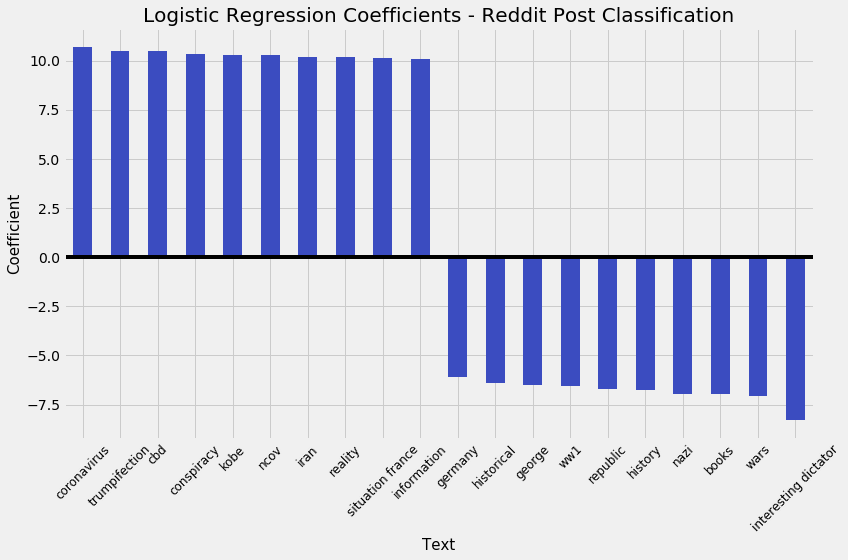

In [99]:
fig = log_bar.plot.bar('text', 'coefficient', figsize=(12, 8), legend=False, cmap='coolwarm')
fig.set_xlabel('Text', size=15)
plt.xticks(size=12, rotation=45)
plt.axhline(color='black')
fig.set_ylabel('Coefficient', size=15)
fig.set_title('Logistic Regression Coefficients - Reddit Post Classification', size=20);
plt.tight_layout()


## TFIDF Vectorization

In [36]:
# instantiate TFIDF with paramters to strip ascii accents, n-gram range of 2 words, and the English set of stop word
tv = TfidfVectorizer(strip_accents='ascii', ngram_range = (1,2), min_df = 2, stop_words = 'english')
X_train_tvs = tv.fit_transform(X_train['title'])
X_test_tvs = tv.transform(X_test['title'])

## Logical Regression with TFIDF

In [37]:
grid_logreg = GridSearchCV(LogisticRegression(), param_grid = {'penalty': ['l1', 'l2'], 
                                                               'C': [1e3, 1e4, 1e5]})

In [38]:
grid_logreg.fit(X_train_tvs, y_train) # fitting our model on the vectorized X

/Users/dylanblough/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/dylanblough/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1000.0, 10000.0, 100000.0],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [39]:
grid_logreg.score(X_train_tvs, y_train), grid_logreg.score(X_test_tvs, y_test)

(0.994060876020787, 0.9339762611275965)

In [40]:
preds = grid_logreg.predict(X_test_tvs)

cm = confusion_matrix(y_test, preds)

cm_df = pd.DataFrame(cm, columns=['Predicted History', 'Predicted Conspiracy'], 
                     index=['Actual History', 'Actual Conspiracy'])
cm_df

,Predicted History,Predicted Conspiracy
Actual History,661,43
Actual Conspiracy,46,598


In [41]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel() # Note that .ravel() will arrange items in 1d array
spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

roc = roc_auc_score(y_test, grid_logreg.predict(X_test_tvs)) # finding the area under the curve

print(f'ROC AUC Score: {round(roc,4)}')

Specificity: 0.9389
Sensitivity: 0.9286
ROC AUC Score: 0.9337


In [42]:
log_df_2 = pd.DataFrame(grid_logreg.best_estimator_.coef_, columns=tv.get_feature_names())
log_df_2.T.sort_values(0, ascending=False).head(10)

,0
mystery,23.563473
seeking,21.939783
kobe,21.871208
email,19.502928
coronavirus,19.112371
effect,18.407269
virus,17.808456
conspiracy,17.269711
truth,16.288751
iran,16.240436


In [43]:
log_df_2.T.sort_values(0, ascending=True).head(10)

,0
did,-24.690065
events,-19.388912
history,-19.137689
societies,-18.011667
romans,-17.917512
1918,-17.654719
build,-17.638965
bad,-17.410681
communism,-17.236491
literary,-17.098064


In [62]:
# plotting 

bar_positive = log_df_2.T.sort_values(0, ascending=False).head(10)

bar_negative = log_df_2.T.sort_values(0, ascending=False).tail(10)

log_bar = bar_positive.append(bar_negative)

log_bar.rename(columns={0: 'coefficient'}, inplace=True)

log_bar['text'] = log_bar.index

In [ ]:
fig = log_bar.plot.bar('text', 'coefficient', figsize=(12, 8), legend=False, cmap='winter')
fig.set_xlabel('Text', size=15)
plt.xticks(size=12, rotation=45)
plt.axhline(color='black')
fig.set_ylabel('Coefficient', size=15)
fig.set_title('Logistic Regression Coefficients - Reddit Post Classification', size=20);
plt.tight_layout()


We balanced out the sensitivity/specificity a little more this time so we've cut down on our False Negatives since the last model!

## Bagging Classifier

A bagging classifier (short for bootstrap aggregating) classifier fits many classifiers onto random samples of the original data and averages them to generate a prediction. In this case shown below, I average the results of 10 decision trees. Bagging estimators are an effective way to reduce the variance of a single estimator.

In [44]:
%%time
grid_bag = GridSearchCV(BaggingClassifier(), param_grid={'n_estimators': [25],
                                                         'random_state': [32]})
grid_bag.fit(X_train_tvs, y_train)

/Users/dylanblough/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 2.97 s, sys: 9.79 ms, total: 2.98 s
Wall time: 2.98 s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
                                         bootstrap_features=False,
                                         max_features=1.0, max_samples=1.0,
                                         n_estimators=10, n_jobs=None,
                                         oob_score=False, random_state=None,
                                         verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'n_estimators': [25], 'random_state': [32]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [45]:
grid_bag.score(X_train_tvs, y_train), grid_bag.score(X_test_tvs, y_test)

(0.991833704528582, 0.9228486646884273)

In [46]:
preds = grid_logreg.predict(X_test_tvs)

cm = confusion_matrix(y_test, preds)

cm_df = pd.DataFrame(cm, columns=['Predicted History', 'Predicted Conspiracy'], 
                     index=['Actual History', 'Actual Conspiracy'])
cm_df

,Predicted History,Predicted Conspiracy
Actual History,661,43
Actual Conspiracy,46,598


In [47]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel() # Note that .ravel() will arrange items in 1d array
spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

roc = roc_auc_score(y_test, grid_logreg.predict(X_test_tvs)) # finding the area under the curve

print(f'ROC AUC Score: {round(roc,4)}')

Specificity: 0.9389
Sensitivity: 0.9286
ROC AUC Score: 0.9337


## Random Forest Classifier¶

A random forest fits a number of decision tree classifiers on sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The samples are drawn with replacement to produce samples of the same size as the originally input data.

In [48]:
%%time
gscv_rfc = GridSearchCV(RandomForestClassifier(), param_grid={'n_estimators': [50, 100],
                                                             'n_jobs': [-1],
                                                             'min_samples_split': [3],
                                                             'min_samples_leaf': [2]})
gscv_rfc.fit(X_train_tvs, y_train)

/Users/dylanblough/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 682 ms, sys: 135 ms, total: 817 ms
Wall time: 3.2 s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [49]:
gscv_rfc.score(X_train_tvs, y_train), gscv_rfc.score(X_test_tvs, y_test)

(0.9599109131403119, 0.8857566765578635)

In [50]:
preds = gscv_rfc.predict(X_test_tvs)

cm = confusion_matrix(y_test, preds)

cm_df = pd.DataFrame(cm, columns=['Predicted History', 'Predicted Conspiracy'], 
                     index=['Actual History', 'Actual Conspiracy'])
cm_df

,Predicted History,Predicted Conspiracy
Actual History,679,25
Actual Conspiracy,129,515


In [52]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel() # Note that .ravel() will arrange items in 1d array
spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

roc = roc_auc_score(y_test, gscv_rfc.predict(X_test_tvs)) # finding the area under the curve

print(f'ROC AUC Score: {round(roc,4)}')

Specificity: 0.9645
Sensitivity: 0.7997
ROC AUC Score: 0.8821


## Bagging Random Forest

Bagging classification with the Random Forest Classifier estimator.

In [53]:
%%time

gs_bag_rf = GridSearchCV(BaggingClassifier(), param_grid={'base_estimator': [RandomForestClassifier()],
                                                           'n_estimators': [10],
                                                           'random_state': [32]})
gs_bag_rf.fit(X_train_tvs, y_train)

/Users/dylanblough/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/dylanblough/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/dylanblough/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/dylanblough/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.

CPU times: user 1.42 s, sys: 18.5 ms, total: 1.43 s
Wall time: 1.44 s


/Users/dylanblough/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/dylanblough/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/dylanblough/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/dylanblough/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Use

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
                                         bootstrap_features=False,
                                         max_features=1.0, max_samples=1.0,
                                         n_estimators=10, n_jobs=None,
                                         oob_score=False, random_state=None,
                                         verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'base_estimator': [RandomForestClassifier(bootstra...
                                                                   max_leaf_nodes=None,
                                                                   min_impurity_decrease=0.0,
                                                                   min_impurity_split=None,
                                                                   min_samples_leaf=1,
                         

In [54]:
gs_bag_rf.score(X_train_tvs, y_train), gs_bag_rf.score(X_test_tvs, y_test)

(0.9873793615441723, 0.9332344213649851)

In [55]:
preds = gs_bag_rf.predict(X_test_tvs)

cm = confusion_matrix(y_test, preds)

cm_df = pd.DataFrame(cm, columns=['Predicted History', 'Predicted Conspiracy'], 
                     index=['Actual History', 'Actual Conspiracy'])
cm_df

,Predicted History,Predicted Conspiracy
Actual History,691,13
Actual Conspiracy,77,567


In [57]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel() # Note that .ravel() will arrange items in 1d array
spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

roc = roc_auc_score(y_test, gs_bag_rf.predict(X_test_tvs)) # finding the area under the curve

print(f'ROC AUC Score: {round(roc,4)}')

Specificity: 0.9815
Sensitivity: 0.8804
ROC AUC Score: 0.931


## Support Vector Machine (SVM)

In [58]:
%%time
gs_svm = GridSearchCV(SVC(), param_grid = {'kernel': ['rbf'],
                                             'random_state': [32],
                                             'gamma': [0.1, 0.05, 0.001]})
gs_svm.fit(X_train_tvs, y_train)

/Users/dylanblough/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 670 ms, sys: 6.07 ms, total: 676 ms
Wall time: 677 ms


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'gamma': [0.1, 0.05, 0.001], 'kernel': ['rbf'],
                         'random_state': [32]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [59]:
gs_svm.score(X_train_tvs, y_train), gs_svm.score(X_test_tvs, y_test)

(0.9146250927988122, 0.8264094955489614)

In [60]:
preds = gs_svm.predict(X_test_tvs)

cm = confusion_matrix(y_test, preds)

cm_df = pd.DataFrame(cm, columns=['Predicted History', 'Predicted Conspiracy'], 
                     index=['Actual History', 'Actual Conspiracy'])
cm_df

,Predicted History,Predicted Conspiracy
Actual History,697,7
Actual Conspiracy,227,417


In [61]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel() # Note that .ravel() will arrange items in 1d array
spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

roc = roc_auc_score(y_test, gs_svm.predict(X_test_tvs)) # finding the area under the curve

print(f'ROC AUC Score: {round(roc,4)}')

Specificity: 0.9901
Sensitivity: 0.6475
ROC AUC Score: 0.8188


## Model Selection and Interpretation

| Model Type                          | Train Score | Test Score | ROC AUC Score |
|-------------------------------------|-------------|------------|---------------|
| CountVectorizer Naive Bayes         | .9821       | .93224     | .9325         |
| CountVectorizer Logistic Regression | 1.0         | .9525      | .952          |
| TFIDF Logistic Regression           | .9940       | .9339      | .9337         |
| TFIDF Bagging                       | .9918       | .92284     | .9337         |
| TFIDF  Random Forest                | .9599       | .8857      | .8821         |
| TFIDF Bagging Random Forest         | .9873       | .9332      | .931          |
| TFIDF SVM                           | .9146       | .8264      | .8188         |

From the above table we can see that the CountVectorized Logistic Regression scored the best across the training and test data, followed closely by the TFIDF Bagging and Bagging Random Forest models. It makes sense that these 2 were 2nd and 3rd best since they are designed to make sure that one feature does not have undue influence on th predictions, which is think is helpful in this case because so many of the /r/conspiracy posts have to do with the CoronaVirus outbreak which tips the model.